<a href="https://colab.research.google.com/github/nik1806/Semantic-segmentation/blob/master/Vision_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [1]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf VOCtrainval_11-May-2012.tar

In [2]:
# !pip install scipy==1.1.0
# !pip install ipywidgets

### 1.1 Loading the dataset

In [3]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

# from PIL import Image
import PIL.Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms

from datasets.pascalVOC import pascalVOCDataset

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [4]:
import torch.nn as nn
# from torchvision.models import segmentation
from models.networkT1 import UNet    

In [5]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
# model = Segnet()
model = UNet()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/nipa00002/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [6]:
local_path = '../datasets/VOCdevkit/VOC2012/' # modify it according to your device
bs = 32 # test with 16, 32 and 64 (select the best)
epochs = 50 #5 # till 50 (5, 10, ...) (base on time also)
lr = 3e-4

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [7]:
# dataset variable
dst_train = pascalVOCDataset(root=local_path, is_transform=True, img_size=256, split='train') # ADD AUGMENTATION
dst_valid = pascalVOCDataset(root=local_path, is_transform=True, img_size=256, split='val')

# dataloader variable
# using in-built dataloader with reshuffling data at each epoch
trainloader = data.DataLoader(dst_train, batch_size=bs, shuffle=True)
validloader = data.DataLoader(dst_valid, batch_size=bs)

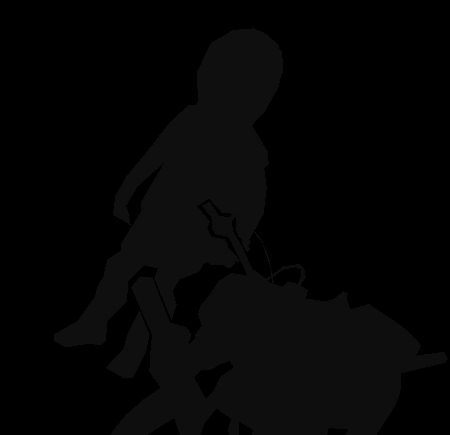

In [8]:
# display pre-encoding
from IPython.display import Image
Image(filename='../datasets/VOCdevkit/VOC2012/SegmentationClass/pre_encoded/2007_000733.png') 

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [9]:
from torch.optim import Adam

# loss function
# the problem is a classification problem (into 21 classes) CrossEntropyLoss works well in this case 
loss_f = nn.CrossEntropyLoss() 

# optimizer variable
# Adam contains both momentum and rmsprop feature, it works well in general
optimizer = Adam(model.parameters(), lr=lr)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [10]:
# check for gpu
if torch.cuda.is_available():
  device = torch.device('cuda:4') # chose available gpu
else:
  device = torch.device('cpu')

# move model
model = model.to(device)

In [ ]:
# save losses in lists
loss_train = []
loss_val = []

for e in range(epochs):

    # putting model in training mode
    model.train()
    total_loss = 0
    for j, (img, label) in enumerate(trainloader):
        # transfer to gpu if available for faster computation
        img, label = img.to(device), label.to(device)
        # clean previous gradients
        optimizer.zero_grad()
        # forward pass through model
        pred = model(img)
#         pred = pred['out'] # output of model is orderedDict
        # loss
        loss = loss_f(pred, label)
        total_loss += loss.item()
        # backward pass
        loss.backward()
        # gradient descent -> update parameters
        optimizer.step()
        
        if j%60 == 0:
            print("epoch{}, iter{}, running loss: {}".format(e, j, total_loss/(bs*(j+1))))

    # print training loss -> later print after epoch or half epoch (costly operation)
    print(f'Epoch {e}: Training loss={total_loss/len(trainloader)}')
    loss_train.append(total_loss/len(trainloader))

    # saving model weights
    torch.save(model.state_dict(), f'../weights/T1/epoch_{e}.pth')

    # validation mode - batchnorm and dropout will working val mode
    model.eval()
    valid_loss = 0
    for (img, label) in validloader:
        img, label = img.to(device), label.to(device) # to gpu
        # deactivate autograd engine - reduce memory usage 
        with torch.no_grad(): 
            pred = model(img) # forward pass
#             pred = pred['out'] # output of model is orderedDict
            loss = loss_f(pred, label) # loss calc
            valid_loss += loss.item()

    print(f'Epoch {e}: Validation loss={valid_loss/len(validloader)}')
    loss_val.append(valid_loss/len(validloader))


model = model.to('cpu')

epoch0, iter0, running loss: 0.10271794348955154
Epoch 0: Training loss=2.2600026519402214
Epoch 0: Validation loss=2.6972916592722354
epoch1, iter0, running loss: 0.053012024611234665
Epoch 1: Training loss=1.5718825614970664
Epoch 1: Validation loss=1.518447767133298
epoch2, iter0, running loss: 0.0448482483625412
Epoch 2: Training loss=1.3065371202385945
Epoch 2: Validation loss=1.2490114180938057
epoch3, iter0, running loss: 0.03717486560344696
Epoch 3: Training loss=1.1370052915552389
Epoch 3: Validation loss=1.1459603426249132
epoch4, iter0, running loss: 0.032884567975997925
Epoch 4: Training loss=1.0564085400622825
Epoch 4: Validation loss=1.0967801822268444
epoch5, iter0, running loss: 0.02894548699259758


In [ ]:
# Plot training and validation loss curves
X = range(1, epochs+1)
plt.plot(X, loss_train, label="Training loss")
plt.plot(X, loss_val, label="Validation loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss curves")
plt.legend() # add legend
plt.savefig('results/T1_loss_curves.png', bbox_inches='tight')
plt.show()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
# import functions
from sklearn.metrics import f1_score
from utils.eval_metrics import dice_coefficient_custom, roc_auc_custom # user defined

def evaluate_batch(gnd_b, pred_b):
    """
        Calculate evalution scores over the batch.
    Args:   
        gnd_b: BxHxW tensor; ground truth labels; each element of matrix in B dim contains class label from (0-20)
        pred_b: BxCxHxW tensor; each element contains predicted class label 
                here C=21 (0-20; no. of classes); each C corresponds to probabilites for that class,
                eg. C=0 contain score at each element in matrix HxW 
    Return:
        f1_score, auc_score, dice_coeeficient (averaged over batch size)
    """
    # to cpu and as numpy ndarray
    gnd_b = gnd_b.cpu().numpy()

    batch_size = gnd_b.shape[0]
    
    # extract most probable class through C-dim 
    label_b = torch.argmax(pred_b, dim=1).cpu().numpy()

    # initial value
    f1 = auc = dice = 0
    # iterate over batch elements
    for i in range(batch_size):
        gnd = gnd_b[i,:,:] 
        label = label_b[i,:,:]
        f1 += f1_score(gnd.flatten(), label.flatten(), average='macro')
        # auc += roc_auc_score(gnd.flatten(), label.flatten(), average='micro', multi_class='ovr')
        auc += roc_auc_custom(gnd, label, average='macro')
        dice += dice_coefficient_custom(gnd, label)

    return [f1/batch_size, auc/batch_size, dice/batch_size]

In [ ]:
# list of score 
f1_list = []; auc_list = []; dice_list = []
print(f'Epochs\t F1-score\t ROC-AUC-score\t Dice-coefficient')

# move model to gpu
model = model.to(device)
# loop for original number of epochs
for i in range(epochs):
    # load the model states
    model.load_state_dict(torch.load(f'../weights/T1/epoch_{i}.pth'))
    # model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
    model.eval()
    # evaluation score variables to store values over each epoch
    f_one = roc_auc = dice_coef = 0 

    for img, label in trainloader:
        img, label = img.to(device), label.to(device) # to gpu
        # deactivate autograd engine - reduce memory usage 
        with torch.no_grad(): 
            pred = model(img) # forward pass
            # output of model is orderedDict
#             pred = pred['out'] # Batchx21(class)xHxW
            # evaluation
            scores = evaluate_batch(label, pred)
            # sum values
            f_one += scores[0]
            roc_auc += scores[1]
            dice_coef += scores[2]
    
    print('{}\t {:.3f}\t\t {:.3f}\t\t {:.3f}'.format(i , f_one/len(trainloader), roc_auc/len(trainloader), dice_coef/len(trainloader)))
#     print(f'Epoch{i+1}:',f_one/len(trainloader), roc_auc/len(trainloader), dice_coef/len(trainloader))
    # append to list (with averaged values over valid set)
    f1_list.append(f_one/len(trainloader))
    auc_list.append(roc_auc/len(trainloader))
    dice_list.append(dice_coef/len(trainloader))

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [ ]:
# PLOT
X = range(1, epochs+1)
plt.plot(X, f1_list, label="F1-score")
plt.plot(X, auc_list, label="AUC-ROC score")
plt.plot(X, dice_list, label="Dice coefficient")
plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T1_eval_metrics.png', bbox_inches='tight')
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [ ]:
from datasets.custom_transforms import unNormalize, decode_segmap

# move model to gpu
model = model.to(device)
# load the model states
model.load_state_dict(torch.load(f'../weights/T1/epoch_{epochs-1}.pth'))
# model.load_state_dict(torch.load(f'weights/T1/epoch_{13}.pth'))

# model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
model.eval()
# iterator on training data
data = iter(trainloader)
# init figure object
fig = plt.figure(figsize=(10,40))
pred_rgb = list()
# for img, label in trainloader:
for i in range(10):
    imgs, labels = next(data) # next batch
    # img, label = img.to(device).unsqueeze(0), label.to(device) # to gpu
    # using just one image
    img = imgs[0].to(device).unsqueeze(0) # to gpu
    # gnd = np.asarray(label[0]) 
    # deactivate autograd engine - reduce memory usage 
    with torch.no_grad(): 
        pred = model(img) # forward pass
        # output of model is orderedDict
#         pred = pred['out'] # 21(class)xHxW
        pred = pred.squeeze(0)
        
        # extract most probable class through C-dim 
        pred_label = torch.argmax(pred, dim=0).cpu().numpy()
        # convert labels to color code
#         pred_rgb = dst_train.decode_segmap(pred_label)
        pred_rgb = decode_segmap(pred_label)

        # plotting
        # original image
        fig.add_subplot(10, 3, 3*i+1)
        img = imgs[0].data.cpu().numpy() # data in image and current form of matrix
        img = unNormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # unNormalize
        img = img.transpose((1,2,0)).astype(np.uint8) # change dtype to correct format for display
        plt.title('Original')
        plt.imshow(img) # original
        plt.axis('off')
        # ground truth
        fig.add_subplot(10, 3, 3*i+2)
        label = labels[0].data.numpy() # data in image and current form of matrix
        label = decode_segmap(label)
#         label = dst_train.decode_segmap(label)
        plt.title('Ground truth')
        plt.imshow(label) 
        plt.axis('off')
        # prediction
        fig.add_subplot(10, 3, 3*i+3)
        plt.title('Prediction')
        plt.imshow(pred_rgb.astype(np.uint8))
        plt.axis('off')

plt.savefig('results/T1_results.png', bbox_inches='tight')    
plt.plot()



